In [1]:
#importing relevant libraries

import pandas as pd
import numpy as np
import datetime
from datetime import date
import holidays
import warnings
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [2]:
# importing data
accepted_data = pd.read_csv('../data/lc_data/accepted_2007_to_2018Q4.csv')
# rejected_data = pd.read_csv('../data/lc_data/rejected_2007_to_2018Q4.csv')

### Selecting years
The dataset ranges from 2007 to 2018. Since The Lending Club was launched in 2012, there may have been significant changes in its loan portfolios since then.

In [3]:
# loan issued after 2012
accepted_data.term = accepted_data.term.apply(str)
accepted_data['term'] = accepted_data['term'].apply(lambda x: x.strip().split(" ")[0])

accepted_data.issue_d = pd.to_datetime(accepted_data.issue_d)
accepted_data['issue_yr'] = accepted_data.issue_d.dt.year


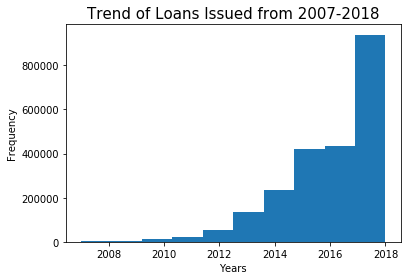

In [4]:
plt.title('Trend of Loans Issued from 2007-2018', fontsize= 15)
plt.xlabel('Years')
accepted_data['issue_yr'].plot.hist()

In [5]:
accepted_data = accepted_data.dropna(subset=['issue_yr'])
accepted_data.shape

(2260668, 152)

In [6]:
accepted_data = accepted_data.dropna(subset=['emp_length'])
accepted_data.shape

(2113761, 152)

In [7]:
accepted_data.issue_yr.unique()

array([2015., 2018., 2017., 2016., 2014., 2011., 2010., 2009., 2008.,
       2007., 2013., 2012.])

In [8]:
# selecting years from 2012-2018
print(accepted_data.shape)
accepted_data = accepted_data.loc[(accepted_data['issue_yr'] > 2011)]
print(accepted_data.shape)
print(accepted_data.issue_yr.unique())

(2113761, 152)
(2072338, 152)
[2015. 2018. 2017. 2016. 2014. 2013. 2012.]


It can be seen that the loan issuance started escalating after 2012 when the Lending Club was launched. Moreover, since it is required to analyze data for at least 5 years, I choose to train my model for 2012-2017 and test it for 2018.

Since the dataset contains both completed and intermidiate loans, for default prediction I would take only the Fully Paid, Charged Off and Default since they are the final state. A loan must either be Fully Paid or be Charged Off/Default (if it takes too long to pay back). A loan payoff can be late but if at the moment of record, it is fully paid then it is fully paid.

In [9]:
# drop all intermediate loans
print(accepted_data.shape)
accepted_data = accepted_data[(accepted_data.loan_status == 'Fully Paid') |
                              (accepted_data.loan_status =='Charged Off') |
                              (accepted_data.loan_status == 'Does not meet the credit policy. Status:Fully Paid') |
                              (accepted_data.loan_status == 'Does not meet the credit policy. Status:Charged Off') | 
                              (accepted_data.loan_status == 'Default')]
print(accepted_data.shape)
print(accepted_data.loan_status.unique())

(2072338, 152)
(1228126, 152)
['Fully Paid' 'Charged Off' 'Default']


### NOTE
The analysis below will be based on loans that are COMPLETED. 

In [10]:
# I decide to drop several columns because they are a linear combination of others, or they contain too little information. 
# For eg. for Zip Code, we only have the first 3 number so this feature is not helpful.
# drop columns mannualy
print(accepted_data.shape)
accepted_data = accepted_data.drop(['title', 'url', 'desc', 'member_id','out_prncp_inv',
                                    'total_pymnt_inv','zip_code','policy_code', 'tax_liens',
                                    'tax_liens','sub_grade','debt_settlement_flag', 'application_type', 
                                    'hardship_flag', 'disbursement_method', 'initial_list_status', 'pymnt_plan',
                                    'avg_cur_bal'], axis = 1)

print(accepted_data.shape)

(1228126, 152)
(1228126, 135)


In [11]:
#drop columns based on threshhold with atleast 20% null values
columns_with_atleast_20_percent_NA_values = [column for column in accepted_data if accepted_data[column].count() / len(accepted_data) <= 0.8]

In [12]:
print(accepted_data.shape)
# columns_with_atleast_20_percent_NA_values
# print(accepted_sample.shape)
accepted_data = accepted_data.drop(columns_with_atleast_20_percent_NA_values, axis=1)

print(accepted_data.shape)

(1228126, 135)
(1228126, 79)


In [114]:
# accepted_data.info(verbose=True, null_counts = True)

After cleaning the dataframe, let's see the description of some of the important variables.

In [14]:
# descriptive statistics for numeric variables
numeric_variables = ['loan_amnt','funded_amnt','int_rate', 'annual_inc', 'fico_range_low','fico_range_high', 'installment']
accepted_data[numeric_variables].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1228126.0,14705.168912,8763.735751,1000.00,8000.00,12500.00,20000.00,40000.00
funded_amnt,1228126.0,14704.793279,8763.447110,1000.00,8000.00,12500.00,20000.00,40000.00
int_rate,1228126.0,13.270808,4.794273,5.31,9.75,12.74,16.02,30.99
annual_inc,1228126.0,78160.485692,71272.694759,0.00,48000.00,65000.00,93000.00,10999200.00
fico_range_low,1228126.0,695.540714,31.349915,660.00,670.00,690.00,710.00,845.00
fico_range_high,1228126.0,699.540844,31.350538,664.00,674.00,694.00,714.00,850.00
installment,1228126.0,446.591825,263.125163,4.93,255.14,382.55,592.73,1719.83


In [15]:
# descriptive statistics for categorical variables
categorical_variables = ['grade', 'id', 'term', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 
                         'loan_status', 'purpose', 'addr_state' ]
accepted_data[categorical_variables].describe().transpose()        

,count,unique,top,freq
grade,1228126,7,B,358326
id,1228126,1228126,14680062,1
term,1228126,2,36,926277
emp_title,1221711,356748,Teacher,21263
emp_length,1228126,11,10+ years,433310
home_ownership,1228126,6,MORTGAGE,612051
verification_status,1228126,3,Source Verified,496310
loan_status,1228126,3,Fully Paid,986102
purpose,1228126,14,debt_consolidation,719314
addr_state,1228126,51,CA,179406


**Rest of the variables will be chosen based on EDA or own understanding of data for the model.**

In [16]:
# looking at only defaulted loans:
default_categories = ['Default', 'Charged Off']

# logistic regression variable default
# Default is 1 
# No default is 0
def get_default_status(loan_status):
    if loan_status in default_categories:
        return 1
    else:
        return 0

In [17]:
accepted_data['default_logit'] = accepted_data['loan_status'].apply(get_default_status)

In [18]:
accepted_data.shape

(1228126, 80)

**Performing EDA on the dataset**

In [19]:
# I transform a few variables into the date type for easier analysis later

accepted_data.home_ownership = accepted_data.home_ownership.replace(['ANY', 'NONE','OTHER'], 'RENT')


accepted_data['issue_yr'] = pd.DatetimeIndex(accepted_data['issue_d']).year
# accepted_data['earliest_cr_line'] = pd.to_datetime(accepted_data.earliest_cr_line)
# accepted_data['early_cr_yr'] = accepted_data.earliest_cr_line.dt.year

# median_year = accepted_data.emp_length.value_counts(ascending = False).index[0]
# accepted_data.loc[:, 'emp_length'] = accepted_data.loc[:, 'emp_length'].fillna(median_year)

accepted_data.emp_length = accepted_data.emp_length.replace(['10+ years'], '10 years')
accepted_data.emp_length = accepted_data.emp_length.replace(['< 1 year'], '0 years')

accepted_data.emp_length = accepted_data.emp_length.apply(lambda x: int(str(x).split(' ')[0]))
print('Loan Issuance based on Employment Length in years')
print(accepted_data.emp_length.value_counts())

Loan Issuance based on Employment Length in years
10    433310
2     117357
3     103504
0     103475
1      85248
5      80868
4      77114
6      60504
8      59219
7      57849
9      49678
Name: emp_length, dtype: int64


In [20]:
accepted_data.loc[:, 'emp_title'] = accepted_data.loc[:, 'emp_title'].fillna('other')
accepted_data.emp_title = accepted_data.emp_title.apply(lambda x: x.lower())
accepted_data.emp_title = accepted_data.emp_title.replace(['lpn','registered nurse', 'rn'], 'nurse')
accepted_data.emp_title.nunique()

306873

Since there are 306873 unique employment titles, therefore it cannot be efficiently used for modelling. Hence remove it.

In [21]:
# loan statuses
# accepted_data['loan_status'].unique()
accepted_data.loan_status.value_counts()

Fully Paid     986102
Charged Off    241989
Default            35
Name: loan_status, dtype: int64

Change of rates through time
Each loan receives a grade that ranges from G through A. Starting November 2017, grade F and G are no longer used. These codes will plot the average interest rate according to grate through time.

Text(0.5, 0.98, 'Interest Rate over time and grade')

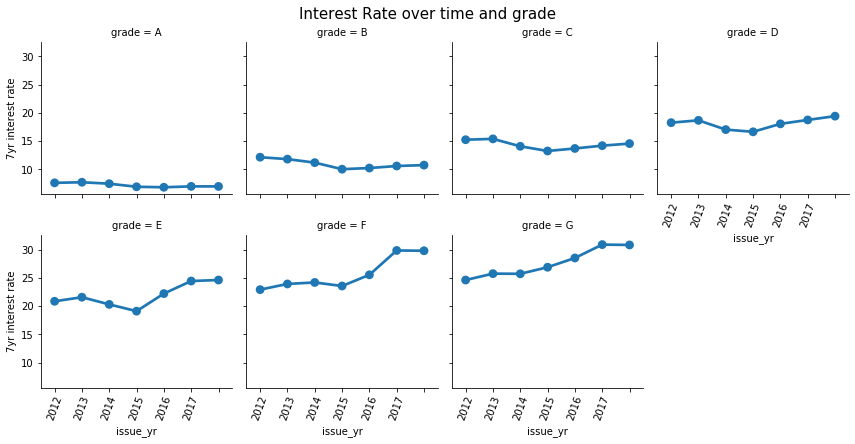

In [22]:
rate = pd.pivot_table(accepted_data[accepted_data['term'] == '36'],
                      index=["grade","issue_yr"],values=["int_rate"], aggfunc=np.mean)
rate = rate.reset_index()

g = sns.FacetGrid(rate, col = 'grade', col_wrap = 4)
g = g.map(sns.pointplot, "issue_yr", "int_rate")

labels = np.arange(2012, 2018, 1)
labels = [str(i) for i in labels]
g = g.set_xticklabels(labels, rotation=70)
g = g.set_ylabels("7yr interest rate")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Interest Rate over time and grade', fontsize= 15)

We can see that interest rate for grade D, E, F, G increase quickly from 2014.

We have very few data points from 2012 to 2014. Let's take a closer look to see if this increase in average rate is not due to the small number of observations.

In [23]:
# Number of observations for each grade
# to verify the variance of rates
rate_count = pd.pivot_table(accepted_data[accepted_data['term'] == '36'],
                            index=["grade","issue_yr"],values=["int_rate"], aggfunc='count')
rate_count = rate_count.unstack('grade')
rate_count

# The number of loans has increased almost exponentially since inception (which is actually 2007)

int_rate                                      
grade           A      B      C      D     E     F    G
issue_yr                                               
2012        10265  16140   9541   4910   760   101   24
2013        16354  38431  23368  13694  3013   553   14
2014        33877  50604  41162  18925  6410  1786  160
2015        66362  85937  72000  29782  8569  1195  221
2016        44364  75160  61852  25372  7138  1715  402
2017        24594  37821  34780  15168  4853   919  485
2018        11272  10787   8967   5191  1208    54   17

In [27]:
# Borrowing purpose
print('Number of loans issued categorised by its purpose')
print(accepted_data.purpose.value_counts().sort_values(ascending=False))

Number of loans issued categorised by its purpose
debt_consolidation    719314
credit_card           272407
home_improvement       78368
other                  68411
major_purchase         25658
medical                13585
small_business         13191
car                    12283
moving                  8325
vacation                8020
house                   6455
wedding                 1327
renewable_energy         781
educational                1
Name: purpose, dtype: int64


In [28]:
# Median of incomes in each grade
income_median = pd.pivot_table(accepted_data, values = 'annual_inc', index = 'grade', aggfunc = np.median)
income_median

,annual_inc
grade,
A,78000.0
B,66000.0
C,63500.0
D,60000.0
E,63000.0
F,65000.0
G,66500.0


   default_logit    annual_inc
0              0  79514.267396
1              1  72644.640792


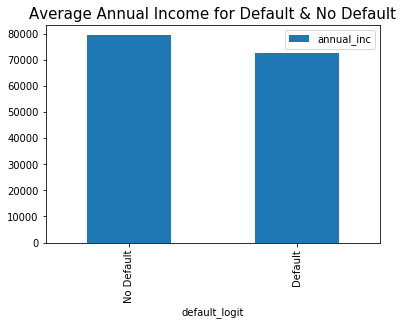

In [29]:
# EDA
a = pd.pivot_table(accepted_data, values = 'annual_inc', index = 'default_logit', aggfunc = np.mean)
print(accepted_data[['annual_inc','default_logit']].groupby(['default_logit'], as_index=False).mean())

average_income_and_default = accepted_data[['annual_inc', 'default_logit']].groupby(['default_logit']).mean().plot(kind='bar')
average_income_and_default.set_xticklabels(('No Default', 'Default'))
plt.title('Average Annual Income for Default & No Default', fontsize= 15)
plt.show()

In [31]:
# statewise analysis of default

df_state_wise_default = accepted_data[['addr_state','default_logit']].groupby(['addr_state'], as_index=False).sum()
df_state_wise_loan_issued = accepted_data.groupby('addr_state',  as_index=False)['issue_yr'].agg('count')
df_state_wise_default = pd.merge(df_state_wise_default, df_state_wise_loan_issued, on='addr_state')
df_state_wise_default['perct_default'] = df_state_wise_default['default_logit']/df_state_wise_default['issue_yr']*100
# df_state_wise_default = df_state_wise_default['perct_default'].round(2)

df_state_wise_default.columns = ['State', 'Default_cases', 'Total_issued','Perct_default']
df_state_wise_default.sort_values(by=['Perct_default'], inplace=True, ascending=False)
print(df_state_wise_default.head(6))
print(df_state_wise_default.tail())

   State  Default_cases  Total_issued  Perct_default
12    IA              1             2      50.000000
25    MS           1536          6035      25.451533
29    NE            832          3402      24.456202
2     AR           2140          8933      23.956118
36    OK           2609         11218      23.257265
1     AL           3464         14927      23.206271
   State  Default_cases  Total_issued  Perct_default
30    NH            850          5961      14.259352
37    OR           2052         14785      13.878931
46    VT            333          2448      13.602941
7     DC            413          3151      13.106950
21    ME            238          1853      12.844037


In [32]:
fico_mean = accepted_data.groupby('default_logit', as_index=False)['fico_range_low', 'fico_range_high'].mean()
fico_mean

,default_logit,fico_range_low,fico_range_high
0,0,697.560141,701.560292
1,1,687.312767,691.312812


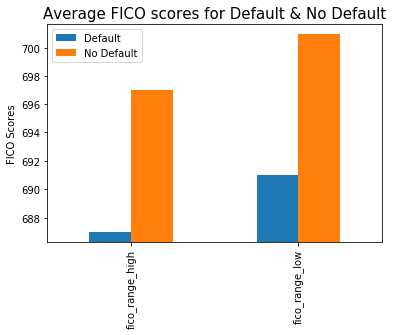

In [33]:
# average FICO scores for default and no default
from matplotlib.ticker import ScalarFormatter

data = [[687, 697], [691, 701]]
df = pd.DataFrame(data, columns=['Default', 'No Default'])
df.plot.bar()
plt.ylabel('FICO Scores')
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.title('Average FICO scores for Default & No Default', fontsize= 15)
x_ticks = ('fico_range_high', 'fico_range_low')
y_ticks = np.arange(688,702,2)
position = np.arange(len(x_ticks))
plt.xticks(position, x_ticks)
plt.yticks(y_ticks)
plt.show()

  Term  Default_cases  Total_issued  Perct_default
0   36         144244        926277      15.572448
1   60          97780        301849      32.393680


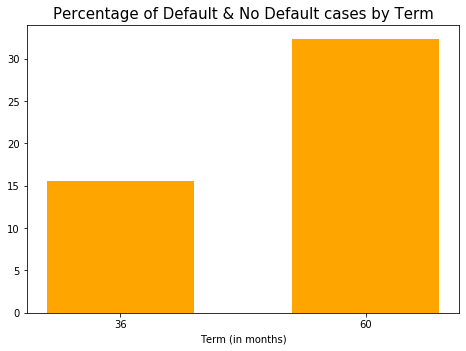

In [34]:
# Term wise default
accepted_data.term.unique()
term_count = accepted_data.groupby('term', as_index=False)['default_logit'].count()
term_count


df_term_wise_default = accepted_data[['term','default_logit']].groupby(['term'], as_index=False).sum()
df_term_wise_loan_issued = accepted_data.groupby('term',  as_index=False)['issue_yr'].agg('count')
df_term_wise_default = pd.merge(df_term_wise_default, df_term_wise_loan_issued, on='term')
df_term_wise_default['perct_term_default'] = df_term_wise_default['default_logit']/df_term_wise_default['issue_yr']*100

df_term_wise_default.columns = ['Term', 'Default_cases', 'Total_issued','Perct_default']
print(df_term_wise_default)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
term = df_term_wise_default['Term'].to_list()
percent = df_term_wise_default['Perct_default'].to_list()
ax.bar(term,percent, width=0.6, color='orange')
plt.title('Percentage of Default & No Default cases by Term', fontsize= 15)
plt.xlabel('Term (in months)')
plt.show()

In [37]:

accepted_data[['grade','default_logit']].groupby(['grade']).agg('count').nunique()
# df_term_wise_loan_issued = accepted_data.groupby('term',  as_index=False)['issue_yr'].agg('count')

default_logit    7
dtype: int64

In [42]:
# Number of observations for each grade
# to verify the variance of rates
rate_count = pd.pivot_table(accepted_data[accepted_data['term'] == '36'],
                            index=["grade","issue_yr"],values=["int_rate"], aggfunc='count')
rate_count = rate_count.unstack('grade')
rate_count

# The number of loans has increased almost exponentially since inception (which is actually 2007)

int_rate                                      
grade           A      B      C      D     E     F    G
issue_yr                                               
2012        10265  16140   9541   4910   760   101   24
2013        16354  38431  23368  13694  3013   553   14
2014        33877  50604  41162  18925  6410  1786  160
2015        66362  85937  72000  29782  8569  1195  221
2016        44364  75160  61852  25372  7138  1715  402
2017        24594  37821  34780  15168  4853   919  485
2018        11272  10787   8967   5191  1208    54   17

In [51]:
grade_count = accepted_data.groupby(['default_logit', 'grade'], as_index=False)['id'].count()
grade_count.columns = ['default_logit', 'grade', 'count']
grade_count

,default_logit,grade,count
0,0,A,200475
1,0,B,311707
2,0,C,273490
3,0,D,127722
4,0,E,52489
5,0,F,16052
6,0,G,4167
7,1,A,12239
8,1,B,46619
9,1,C,77543


In [53]:
# keeping only required columns for regression
final_coulumns = ['loan_amnt', 'term', 'int_rate','default_logit','grade', 'emp_length', 'annual_inc',
                  'home_ownership', 'verification_status', 'purpose', 'issue_yr', 'mort_acc', 'fico_range_low', 
                  'fico_range_high', 'pub_rec']

loan_analysis_columns =  ['loan_amnt', 'term', 'int_rate','default_logit','grade', 'emp_length', 'annual_inc',
                          'home_ownership', 'verification_status', 'purpose', 'issue_yr', 'total_rec_prncp', 
                          'funded_amnt', 'last_pymnt_d', 'issue_d', 'total_rec_int', 'total_pymnt',
                          'installment', 'last_pymnt_amnt']

In [54]:
final_accepted_data = accepted_data[final_coulumns]
print(final_accepted_data.shape)


(1228126, 15)


In [55]:
final_accepted_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1228126.0,14705.168912,8763.735751,1000.00,8000.00,12500.00,20000.00,40000.00
int_rate,1228126.0,13.270808,4.794273,5.31,9.75,12.74,16.02,30.99
default_logit,1228126.0,0.197068,0.397784,0.00,0.00,0.00,0.00,1.00
emp_length,1228126.0,5.997097,3.690814,0.00,3.00,6.00,10.00,10.00
annual_inc,1228126.0,78160.485692,71272.694759,0.00,48000.00,65000.00,93000.00,10999200.00
issue_yr,1228126.0,2015.097067,1.439194,2012.00,2014.00,2015.00,2016.00,2018.00
mort_acc,1220893.0,1.663097,1.996105,0.00,0.00,1.00,3.00,51.00
fico_range_low,1228126.0,695.540714,31.349915,660.00,670.00,690.00,710.00,845.00
fico_range_high,1228126.0,699.540844,31.350538,664.00,674.00,694.00,714.00,850.00
pub_rec,1228126.0,0.213851,0.604797,0.00,0.00,0.00,0.00,86.00


**Regression**

In [57]:
final_accepted_data.columns

Index(['loan_amnt', 'term', 'int_rate', 'default_logit', 'grade', 'emp_length',
       'annual_inc', 'home_ownership', 'verification_status', 'purpose',
       'issue_yr', 'mort_acc', 'fico_range_low', 'fico_range_high', 'pub_rec'],
      dtype='object')

In [58]:
# creating dummy variables for categorical variables
dummies_df_accepted_data = pd.get_dummies(final_accepted_data, columns=['grade','term', 'home_ownership', 'verification_status',
                                                                        'purpose'])
dummies_df_accepted_data.head()
print(dummies_df_accepted_data.shape)
dummies_df_accepted_data = dummies_df_accepted_data.dropna()
print(dummies_df_accepted_data.shape)

(1228126, 39)
(1220893, 39)


In [59]:
# Splitting the data into 2 parts as 2012-2017 (training period) & 2018 (testing period)
is_2018 = dummies_df_accepted_data['issue_yr'] == 2018
testing_df_2018 = dummies_df_accepted_data[is_2018]
# testing_df_2018.head()
testing_df_2018.issue_yr.unique()

array([2018], dtype=int64)

In [60]:
is_2012_to_2017 =  [not i for i in is_2018]
training_df_2012_to_2017 = dummies_df_accepted_data[is_2012_to_2017]
training_df_2012_to_2017.issue_yr.unique()

array([2015, 2017, 2016, 2014, 2013, 2012], dtype=int64)

In [61]:
training_df_2012_to_2017 = training_df_2012_to_2017.drop(['issue_yr'], axis = 1)
testing_df_2018 = testing_df_2018.drop(['issue_yr'], axis = 1)

0    936339
1    233170
Name: default_logit, dtype: int64


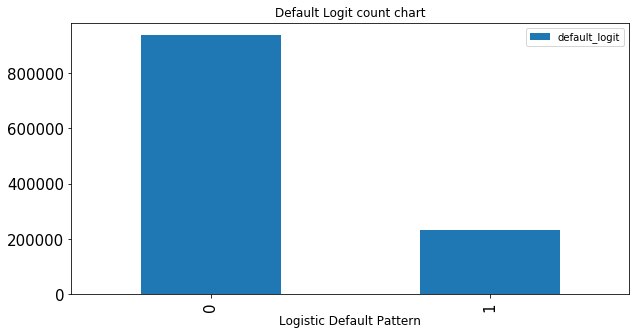

In [62]:
# REBALANCING
# default_logit count chart
import matplotlib.pyplot as plt
default_logit_count = training_df_2012_to_2017['default_logit'].value_counts()
print(default_logit_count)
ax = default_logit_count.plot(kind='bar', title ="Default Logit count chart", figsize=(10, 5), legend=True, fontsize=15)
ax.set_xlabel("Logistic Default Pattern", fontsize=12)
plt.show()

In [64]:
# creating x & y variables for training and testing of models for both the datasets

X_train_2012_to_2017 = training_df_2012_to_2017.loc[:, training_df_2012_to_2017.columns != 'default_logit']
y_train_2012_to_2017 = training_df_2012_to_2017.loc[:, training_df_2012_to_2017.columns == 'default_logit']
X_test_2018 = testing_df_2018.loc[:, testing_df_2018.columns != 'default_logit']
y_test_2018 = testing_df_2018.loc[:, testing_df_2018.columns == 'default_logit']

With our training data created, I’ll up-sample the no-subscription using the SMOTE. It works by creating synthetic samples from the minor class (default) instead of creating copies.

In [66]:
# Rebalancing using SMOTE
os = SMOTE(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train_2012_to_2017.columns
os_data_X, os_data_y=os.fit_sample(X_train_2012_to_2017, y_train_2012_to_2017)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y, columns=['default_logit'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no default in oversampled data",len(os_data_y[os_data_y['default_logit']==0]))
print("Number of default",len(os_data_y[os_data_y['default_logit']==1]))
print("Proportion of no default data in oversampled data is ",len(os_data_y[os_data_y['default_logit']==0])/len(os_data_X))
print("Proportion of default data in oversampled data is ",len(os_data_y[os_data_y['default_logit']==1])/len(os_data_X))

Length of oversampled data is  1872678
Number of no default in oversampled data 936339
Number of default 936339
Proportion of no default data in oversampled data is  0.5
Proportion of default data in oversampled data is  0.5


Now I have a perfect balanced data! It can be noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

**Recursive Feature Elimination**

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [68]:
# feature elimination
from sklearn.feature_selection import RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 25)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)


[False False False False False  True  True False  True  True  True  True
 False  True False  True  True  True  True  True  True  True  True  True
  True  True False  True False  True  True  True  True False  True  True
 False]
[10  8  9 11  6  1  1  5  1  1  1  1 12  1  3  1  1  1  1  1  1  1  1  1
  1  1 13  1  2  1  1  1  1  7  1  1  4]


In [70]:
target_col = []
for col, ranking in zip(columns, rfe.ranking_):
    if ranking == 1:
        target_col.append(col)

# Adding other columns
target_col.extend(['loan_amnt', 'int_rate'])
print(target_col)
print(len(target_col))

['fico_range_low', 'fico_range_high', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_F', 'term_36', 'term_60', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_small_business', 'purpose_vacation', 'loan_amnt', 'int_rate']
27


In [71]:
final_os_data_X = os_data_X[target_col]
final_X_test_2018 = X_test_2018[target_col]

In [72]:
# training the logistic model
logistic_reg = LogisticRegression()
logistic_reg.fit(final_os_data_X, os_data_y)

LogisticRegression()

In [73]:
print(logistic_reg.coef_)
print(logistic_reg.intercept_)

[[-6.01082357e-02  6.59002698e-02 -7.24831940e-01 -1.16094303e+00
  -9.14533363e-01 -8.61929279e-01 -2.24946611e-01 -1.72301273e+00
  -3.64125936e-01 -2.21558353e+00 -6.27963302e-01 -8.70880052e-01
  -1.46761319e+00 -1.33125759e+00 -1.42563262e+00 -6.79549597e-02
  -1.12756153e+00 -1.43573440e+00 -4.19701484e-01 -1.30709632e-01
  -7.46807379e-02 -5.03212106e-02 -3.83772792e-01 -7.28954199e-02
  -4.58774109e-02  9.34810968e-07  6.75865433e-02]]
[0.03152347]


In [74]:
# predicting/testing the data for 2018 based on the model & getting the accuracy score
y_pred_2018 = logistic_reg.predict(final_X_test_2018)
print('Accuracy of logistic regression on test set of 2018: {:.2f}'.format(logistic_reg.score(final_X_test_2018, y_test_2018)))

Accuracy of logistic regression on test set of 2018: 0.73


In [75]:
from sklearn.metrics import confusion_matrix
# creating a confusion matrix to check for false/true positives/negatives
confusion_matrix = confusion_matrix(y_test_2018, y_pred_2018)
print(confusion_matrix)

[[34295  9399]
 [ 4566  3124]]


In [76]:
# extracting the summary report for the model
print(classification_report(y_test_2018, y_pred_2018))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83     43694
           1       0.25      0.41      0.31      7690

    accuracy                           0.73     51384
   macro avg       0.57      0.60      0.57     51384
weighted avg       0.79      0.73      0.75     51384



In [77]:
# default percentage
confusion_matrix[1][1]/(confusion_matrix[0][0] + confusion_matrix[1][1])

0.08348699858360725

## Part IV

In [78]:
loan_portfolio_analysis_df = accepted_data[loan_analysis_columns]
loan_portfolio_analysis_df.head()

,loan_amnt,term,int_rate,default_logit,grade,emp_length,annual_inc,home_ownership,verification_status,purpose,issue_yr,total_rec_prncp,funded_amnt,last_pymnt_d,issue_d,total_rec_int,total_pymnt,installment,last_pymnt_amnt
0,3600.0,36,13.99,0,C,10,55000.0,MORTGAGE,Not Verified,debt_consolidation,2015,3600.0,3600.0,Jan-2019,2015-12-01,821.72,4421.723917,123.03,122.67
1,24700.0,36,11.99,0,C,10,65000.0,MORTGAGE,Not Verified,small_business,2015,24700.0,24700.0,Jun-2016,2015-12-01,979.66,25679.660000,820.28,926.35
2,20000.0,60,10.78,0,B,10,63000.0,MORTGAGE,Not Verified,home_improvement,2015,20000.0,20000.0,Jun-2017,2015-12-01,2705.92,22705.924294,432.66,15813.30
4,10400.0,60,22.45,0,F,3,104433.0,MORTGAGE,Source Verified,major_purchase,2015,10400.0,10400.0,Jul-2016,2015-12-01,1340.50,11740.500000,289.91,10128.96
5,11950.0,36,13.44,0,C,4,34000.0,RENT,Source Verified,debt_consolidation,2015,11950.0,11950.0,May-2017,2015-12-01,1758.95,13708.948530,405.18,7653.56


In [79]:
loan_portfolio_analysis_df['last_pymnt_d']= pd.to_datetime(loan_portfolio_analysis_df['last_pymnt_d'])

In [80]:
loan_portfolio_analysis_df['term_of_payment'] = round(((loan_portfolio_analysis_df['last_pymnt_d'] - loan_portfolio_analysis_df['issue_d']).dt.days)*(12/365))
loan_portfolio_analysis_df.head(2)

,loan_amnt,term,int_rate,default_logit,grade,emp_length,annual_inc,home_ownership,verification_status,purpose,issue_yr,total_rec_prncp,funded_amnt,last_pymnt_d,issue_d,total_rec_int,total_pymnt,installment,last_pymnt_amnt,term_of_payment
0,3600.0,36,13.99,0,C,10,55000.0,MORTGAGE,Not Verified,debt_consolidation,2015,3600.0,3600.0,2019-01-01,2015-12-01,821.72,4421.723917,123.03,122.67,37.0
1,24700.0,36,11.99,0,C,10,65000.0,MORTGAGE,Not Verified,small_business,2015,24700.0,24700.0,2016-06-01,2015-12-01,979.66,25679.660000,820.28,926.35,6.0


In [81]:
# fully_paid_df = loan_analysis_sample.loc[loan_analysis_sample['term_of_payment'] == 36]
# fully_paid_df

In [82]:
# is there prepayment
def find_preypayment(row):
    default_logit = row['default_logit']
    last_pymnt_d = row['last_pymnt_d']
    issue_d = row['issue_d']
    if row['default_logit'] == 1:
        return 'default'
    else:
        d = int(((last_pymnt_d - issue_d).days)*(12/365))
        if d < int(row['term']):
            return 'prepayment'
        elif d > int(row['term']):
            return 'late payment'
        else:
            return 'no prepayment'

loan_portfolio_analysis_df['type_of_payment'] = loan_portfolio_analysis_df.apply(find_preypayment, axis=1)

In [83]:
loan_portfolio_analysis_df.head(2)
# loan_portfolio_analysis_df.columns

,loan_amnt,term,int_rate,default_logit,grade,emp_length,annual_inc,home_ownership,verification_status,purpose,...,total_rec_prncp,funded_amnt,last_pymnt_d,issue_d,total_rec_int,total_pymnt,installment,last_pymnt_amnt,term_of_payment,type_of_payment
0,3600.0,36,13.99,0,C,10,55000.0,MORTGAGE,Not Verified,debt_consolidation,...,3600.0,3600.0,2019-01-01,2015-12-01,821.72,4421.723917,123.03,122.67,37.0,late payment
1,24700.0,36,11.99,0,C,10,65000.0,MORTGAGE,Not Verified,small_business,...,24700.0,24700.0,2016-06-01,2015-12-01,979.66,25679.660000,820.28,926.35,6.0,prepayment


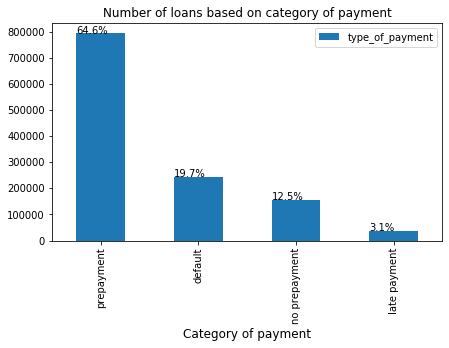

In [84]:
# loans based on types of payment
ax = loan_portfolio_analysis_df['type_of_payment'].value_counts().plot(kind='bar', title ="Number of loans based on category of payment",
                                                                       figsize=(7, 4), legend=True, fontsize=10)
ax.set_xlabel("Category of payment", fontsize=12)
total = len(loan_portfolio_analysis_df['type_of_payment'])
# for p in ax.patches:
#         percentage = '{:.1f}%'.format(100 * p.get_width()/total)
#         x = p.get_x() + p.get_width() + 0.02
#         y = p.get_y() + p.get_height()/2
#         ax.annotate(percentage, (x, y))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(percentage, (x, y + height + 20))
plt.show()

In [85]:
# sample based on filter
def filter_dataframe(df, column_names, column_values):
    df2 = df.copy()
    assert len(column_names) == len(column_values)
    for name, value in zip(column_names, column_values):
        df2 = df2[df2[name] == value]
    return df2.sample(100)

In [112]:
# filtered loan based on conditions case
filtered_loan_analysis_sample = filter_dataframe(loan_portfolio_analysis_df,
                                                 ['grade', 'term', 'verification_status'],
                                                 ['A','36', 'Verified'])

In [94]:
loan_portfolio_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228126 entries, 0 to 2260697
Data columns (total 21 columns):
loan_amnt              1228126 non-null float64
term                   1228126 non-null object
int_rate               1228126 non-null float64
default_logit          1228126 non-null int64
grade                  1228126 non-null object
emp_length             1228126 non-null int64
annual_inc             1228126 non-null float64
home_ownership         1228126 non-null object
verification_status    1228126 non-null object
purpose                1228126 non-null object
issue_yr               1228126 non-null int64
total_rec_prncp        1228126 non-null float64
funded_amnt            1228126 non-null float64
last_pymnt_d           1226114 non-null datetime64[ns]
issue_d                1228126 non-null datetime64[ns]
total_rec_int          1228126 non-null float64
total_pymnt            1228126 non-null float64
installment            1228126 non-null float64
last_pymnt_amnt     

In [107]:
# random 100 loans case
loan_analysis_sample = loan_portfolio_analysis_df.sample(100)

In [108]:
# returns
def find_roi(row):
    prime_rate = 3.25
    if row['type_of_payment'] == 'no prepayment':
        pv =  np.pv(prime_rate/1200,
                     nper=int(row['term']),
                     pmt=int(row['installment']),
                     fv=0)
        npv = -pv - row['funded_amnt']
        ret_on_inv = (npv/row['funded_amnt'])*100
        return ret_on_inv
    
    else:
        installment = int(row['total_pymnt'])/int(row['term'])
        pv =  np.pv(prime_rate/1200,
                     nper=int(row['term_of_payment']),
                     pmt=installment,
                     fv=0)
        npv = -pv - row['funded_amnt']
        ret_on_inv = (npv/row['funded_amnt'])*100
        return ret_on_inv
    
filtered_loan_analysis_sample['ret_on_inv'] = filtered_loan_analysis_sample.apply(find_roi, axis=1)

In [109]:
# average Return on investment based on conditions
filtered_loan_analysis_sample[['ret_on_inv','grade']].groupby(['grade'], as_index=False).mean()


,grade,ret_on_inv
0,A,5.944358
